# Importing Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
import pickle
import itertools
from IPython.display import Image

# Cloning and checking folders from github

In [ ]:
# GitHub repository URL
repo_url = "https://github.com/beingjumana/leukemia-cnn-model.git"

# Clone the repository if it doesn't already exist
if not os.path.exists("leukemia-cnn-model"):
    !git clone {repo_url}

# Change directory to the repository
%cd leukemia-cnn-model

# Define the image folders
dataset_folder = "data"
original_folder = os.path.join(dataset_folder, "Original")
segmented_folder = os.path.join(dataset_folder, "Segmented")

# Define the subfolders for each class
classes = ["Benign", "Early Pre-B", "Pre-B", "Pro-B"]

# Check if the directories exist
if not os.path.exists(original_folder):
    print(f"Directory {original_folder} does not exist.")
if not os.path.exists(segmented_folder):
    print(f"Directory {segmented_folder} does not exist.")

# Define the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load the original images if the directory exists
if os.path.exists(original_folder):
    original_train_dir = original_folder
    original_train_datagen = datagen.flow_from_directory(
        original_train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )
    print("Original images:")
    print(original_train_datagen.class_indices)
else:
    original_train_datagen = None
    print("Original image directory not found.")

# Load the segmented images if the directory exists
if os.path.exists(segmented_folder):
    segmented_train_dir = segmented_folder
    segmented_train_datagen = datagen.flow_from_directory(
        segmented_train_dir,
        target_size=(224, 224),
        batch_size=32,
        class_mode="categorical"
    )
    print("Segmented images:")
    print(segmented_train_datagen.class_indices)
else:
    segmented_train_datagen = None
    print("Segmented image directory not found.")


Cloning into 'leukemia-cnn-model'...
remote: Enumerating objects: 6456, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 6456 (delta 1), reused 4 (delta 0), pack-reused 6446
Receiving objects: 100% (6456/6456), 114.87 MiB | 15.38 MiB/s, done.
Resolving deltas: 100% (31/31), done.
/content/leukemia-cnn-model
Found 3256 images belonging to 4 classes.
Original images:
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}
Found 3256 images belonging to 4 classes.
Segmented images:
{'Benign': 0, 'Early': 1, 'Pre': 2, 'Pro': 3}


# About the Dataset

In [ ]:
# Define the image folders
dataset_folder = "data"
original_folder = os.path.join(dataset_folder, "Original")
segmented_folder = os.path.join(dataset_folder, "Segmented")

# Initialize the image data generator
datagen = ImageDataGenerator(rescale=1./255)

# Load the original images
original_datagen = datagen.flow_from_directory(
    original_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Load the segmented images
segmented_datagen = datagen.flow_from_directory(
    segmented_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Calculate the number of images in each dataset
num_original_images = original_datagen.samples
num_segmented_images = segmented_datagen.samples
num_total_images = num_original_images + num_segmented_images

# Get the class labels
original_classes = list(original_datagen.class_indices.keys())
segmented_classes = list(segmented_datagen.class_indices.keys())

# Print the results
print(f"1 - Name of dataset folders:")
print(f"Original Images Folder: {original_folder}")
print(f"Segmented Images Folder: {segmented_folder}")

print(f"\n2 - Sum of images in each folder:")
print(f"Original Images: {num_original_images}")
print(f"Segmented Images: {num_segmented_images}")

print(f"\n3 - Classes in each folder:")
print(f"Classes in Original Images: {original_classes}")
print(f"Classes in Segmented Images: {segmented_classes}")

print(f"\n4 - Sum of whole dataset:")
print(f"Total Images: {num_total_images}")

Found 3256 images belonging to 4 classes.
Found 3256 images belonging to 4 classes.
1 - Name of dataset folders:
Original Images Folder: data/Original
Segmented Images Folder: data/Segmented

2 - Sum of images in each folder:
Original Images: 3256
Segmented Images: 3256

3 - Classes in each folder:
Classes in Original Images: ['Benign', 'Early', 'Pre', 'Pro']
Classes in Segmented Images: ['Benign', 'Early', 'Pre', 'Pro']

4 - Sum of whole dataset:
Total Images: 6512


# Splitting data in Training and Validation

In [ ]:
# Define the image data generator
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load the original images
original_train_datagen = datagen.flow_from_directory(
    original_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load the segmented images
segmented_train_datagen = datagen.flow_from_directory(
    segmented_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data
original_val_datagen = datagen.flow_from_directory(
    original_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

segmented_val_datagen = datagen.flow_from_directory(
    segmented_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)


Found 2607 images belonging to 4 classes.
Found 2607 images belonging to 4 classes.
Found 649 images belonging to 4 classes.
Found 649 images belonging to 4 classes.


## Sample images

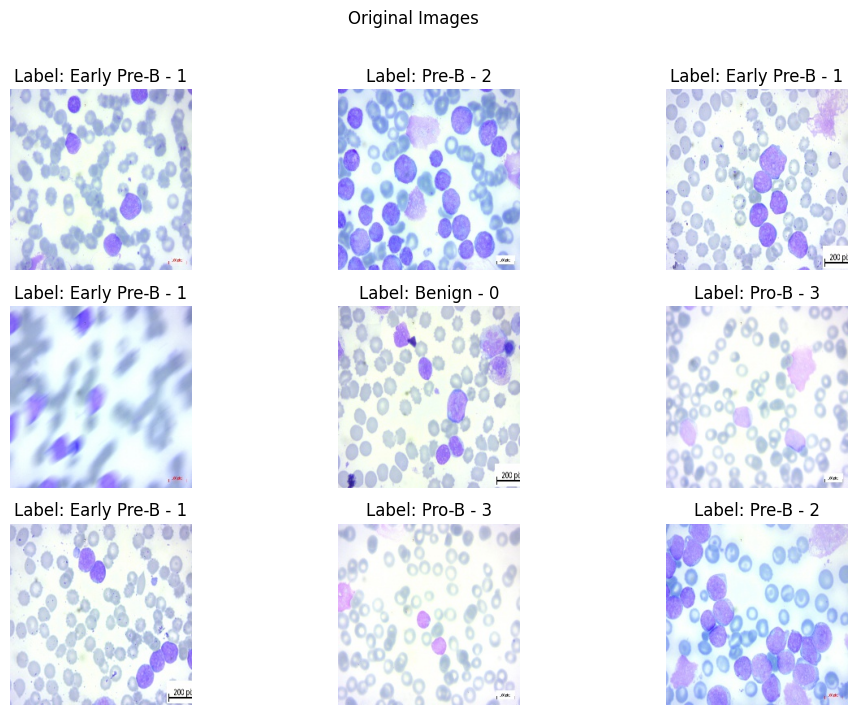

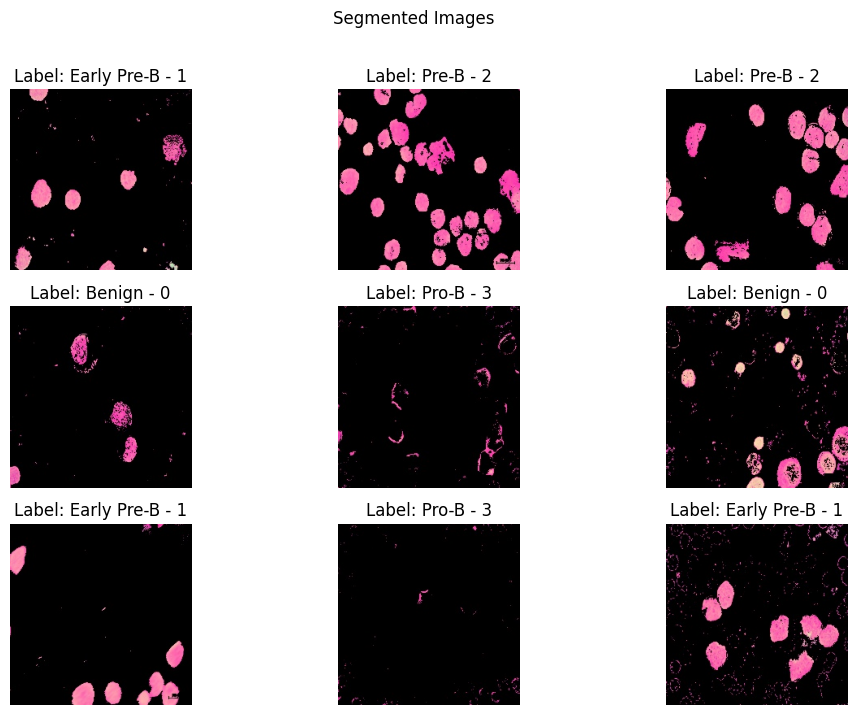

In [ ]:
def plot_sample_images(data_gen, title, class_names):
    plt.figure(figsize=(12, 8))
    batch = next(itertools.islice(data_gen, 1))
    for i in range(9):
        img, label = batch[0][i], batch[1][i]
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        class_index = np.argmax(label)
        plt.title(f"Label: {class_names[class_index]} - {class_index}")
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

# Define class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot sample images
plot_sample_images(original_train_datagen, "Original Images", class_names)
plot_sample_images(segmented_train_datagen, "Segmented Images", class_names)

## SAVE AND LOAD model data and predictions

In [ ]:
#SAVE AND LOAD model data and predictions
def save_data_and_model(model, sample_images, sample_labels, predictions, model_path='model_combined.h5'):
    # Save the model
    model.save(model_path)

    # Save the data
    with open('sample_images.pkl', 'wb') as f:
        pickle.dump(sample_images, f)
    with open('sample_labels.pkl', 'wb') as f:
        pickle.dump(sample_labels, f)
    with open('predictions.pkl', 'wb') as f:
        pickle.dump(predictions, f)

def load_data_and_model(model_path='model_combined.h5'):
    # Load the model
    model = load_model(model_path)

    # Load the data
    with open('sample_images.pkl', 'rb') as f:
        sample_images = pickle.load(f)
    with open('sample_labels.pkl', 'rb') as f:
        sample_labels = pickle.load(f)
    with open('predictions.pkl', 'rb') as f:
        predictions = pickle.load(f)

    return model, sample_images, sample_labels, predictions

## Function to plot learning curve

In [ ]:
# Plot training and validation loss and accuracy
def plot_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend()

    plt.show()



# Model 1 (Original data) with CNN, Early stopping, Learning rate, L2 regularization and Batch normalization

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


82/82 ━━━━━━━━━━━━━━━━━━━━ 41s 348ms/step - accuracy: 0.7962 - loss: 5.6076 - val_accuracy: 0.2465 - val_loss: 10.9706 - learning_rate: 0.0010
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9539 - loss: 2.7943 - val_accuracy: 0.2465 - val_loss: 5.0831 - learning_rate: 0.0010
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - accuracy: 0.9491 - loss: 1.6454 - val_accuracy: 0.3035 - val_loss: 6.5449 - learning_rate: 0.0010
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 85ms/step - accuracy: 0.9650 - loss: 1.4585 - val_accuracy: 0.3035 - val_loss: 4.4366 - learning_rate: 0.0010
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 82ms/step - accuracy: 0.9528 - loss: 1.3730 - val_accuracy: 0.3035 - val_loss: 6.0204 - learning_rate: 0.0010
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 9s 108ms/step - accuracy: 0.9722 - loss: 0.9959 - val_accuracy: 0.0924 - val_loss: 5.2039 - learning_rate: 0.0010
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9580 - loss: 1.3422 - val_accuracy: 

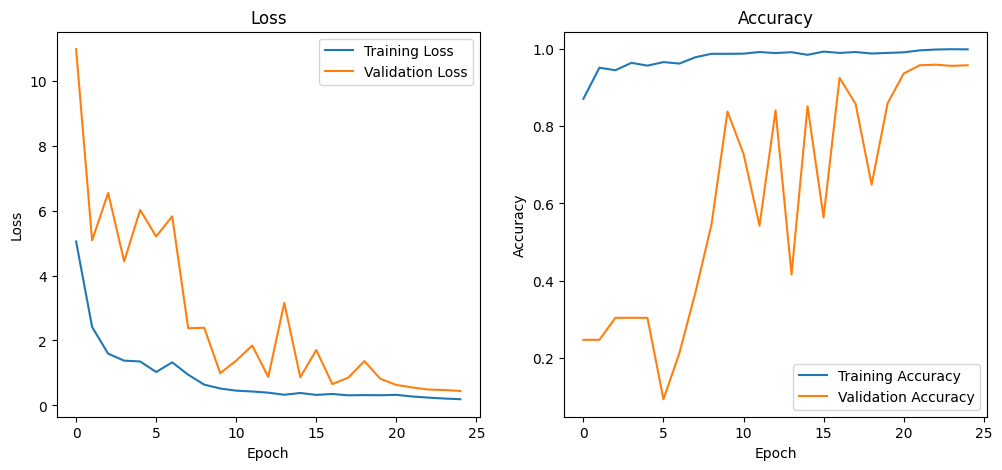

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


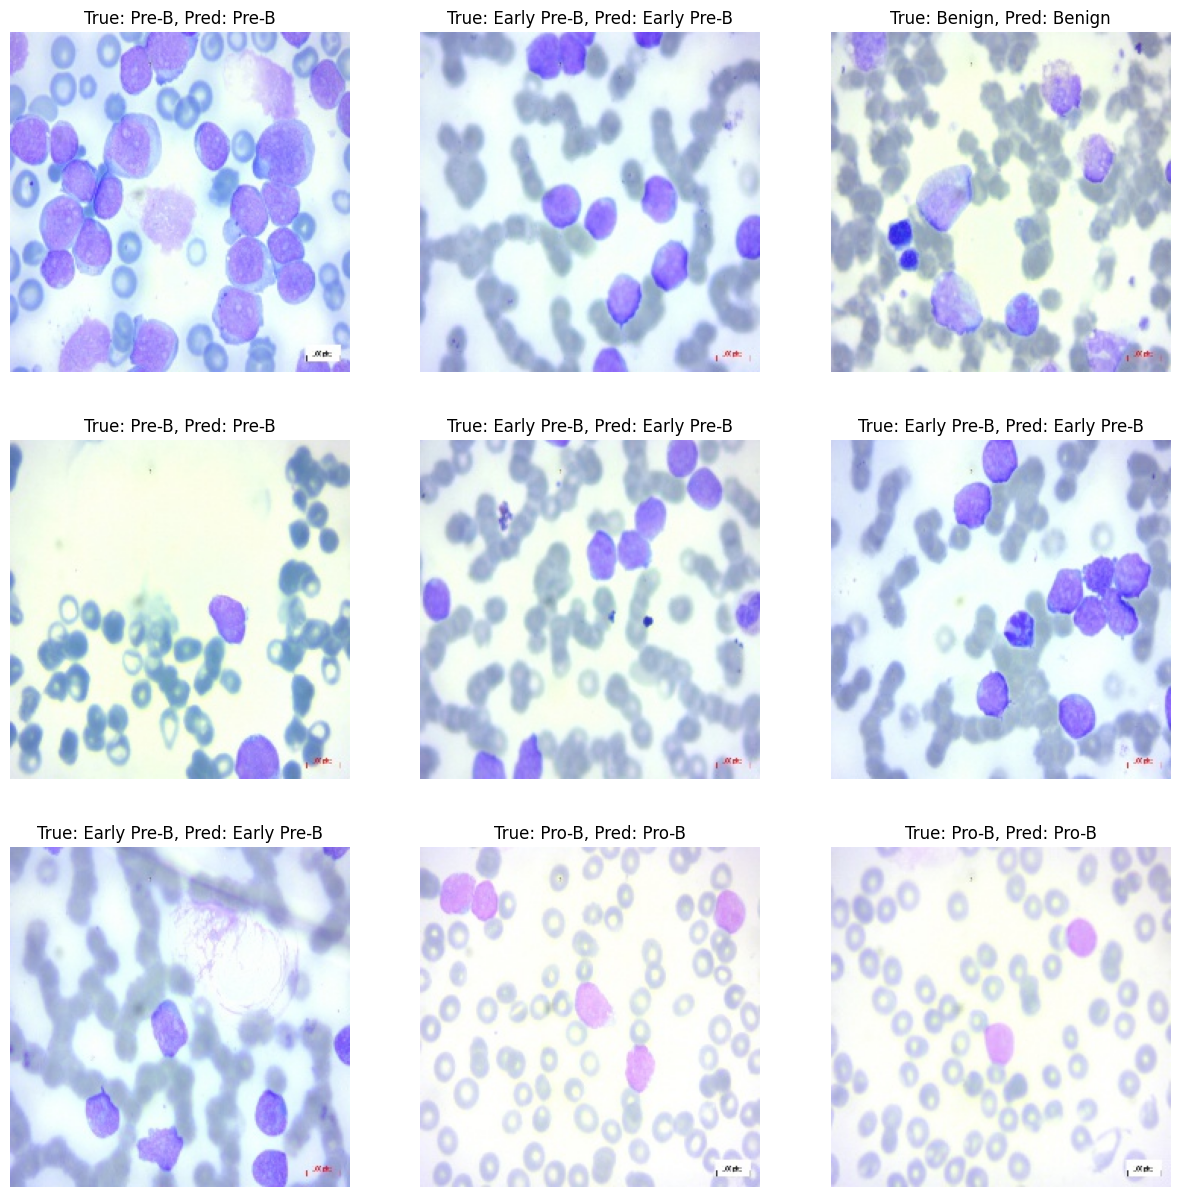

In [ ]:
# Define the CNN model with L2 regularization and Batch Normalization
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint = ModelCheckpoint('model.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history = model.fit(
    original_train_datagen,
    validation_data=original_val_datagen,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# model.save('model.keras')

plot_history(history)


# Get a batch of validation data
sample_images, sample_labels = next(original_val_datagen)

# Predict the classes for the sample images
predictions = model.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
save_data_and_model(model, sample_images, sample_labels, predictions)

# Class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = predicted_classes[i]
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.show()

Observations:
* Training ran for 25 epochs.
* Training accuracy reached 99.99%.
* Validation accuracy peaked at 95.84%.
* Training loss decreased from 6.2 to 0.1948.
* Validation loss decreased from 14 to 0.4442.
* Overfitting indicated by nearly 100% training accuracy vs. 95.84% validation accuracy.
* Learning rate adjustments: 0.001 (epochs 1-7) → 0.0002 (epochs 8-20) → 0.00004 (epochs 21-25).
* Training accuracy improved rapidly, reaching over 95% by epoch 2.
* Validation performance was highly volatile initially but stabilized after epoch 20.
* Notable improvements in validation performance occurred after learning rate reductions.
* Highest validation accuracy: 95.99% (epoch 23).
* Lowest validation loss: 0.4442 (epoch 25).

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,511,246 (127.84 MB)

 Trainable params: 11,170,180 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 22,340,362 (85.22 MB)

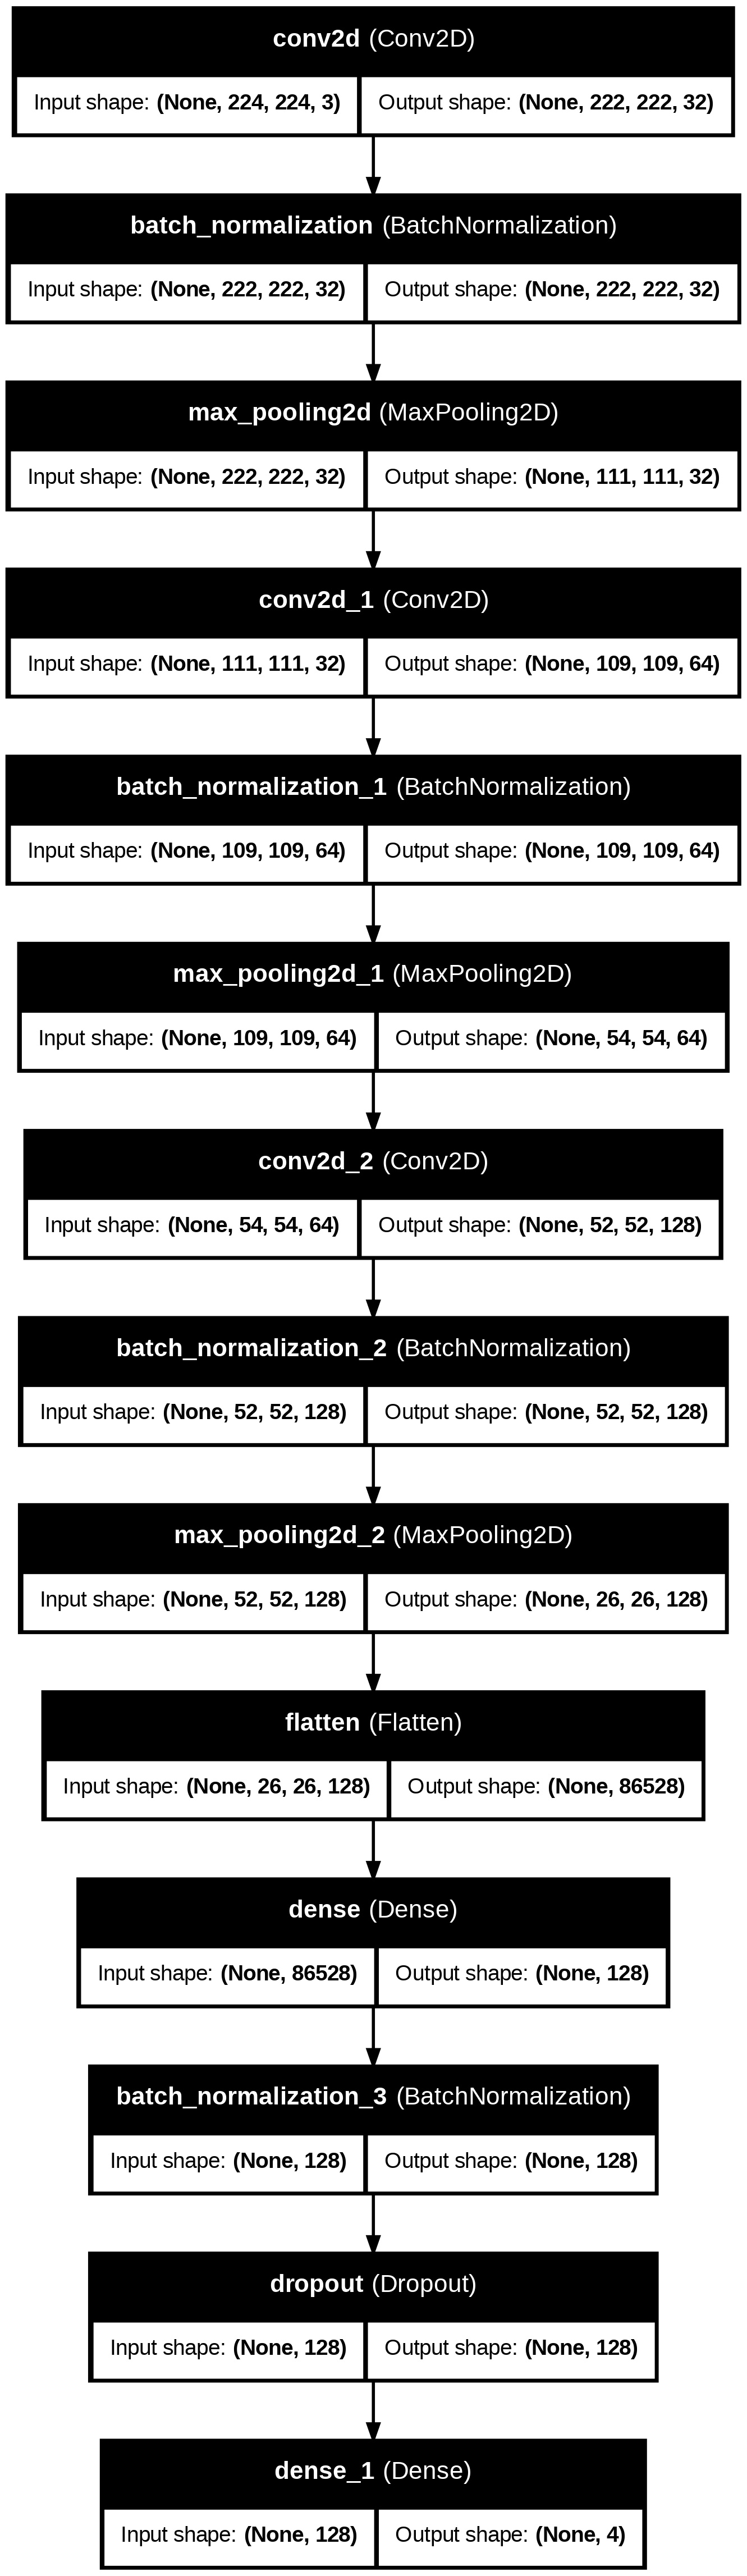

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model.png'))


# Segmented data

Epoch 1/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 21s 172ms/step - accuracy: 0.6958 - loss: 6.1947 - val_accuracy: 0.2465 - val_loss: 14.3756 - learning_rate: 0.0010
Epoch 2/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.8411 - loss: 3.6084 - val_accuracy: 0.2465 - val_loss: 19.9507 - learning_rate: 0.0010
Epoch 3/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.8946 - loss: 2.2589 - val_accuracy: 0.2465 - val_loss: 18.2957 - learning_rate: 0.0010
Epoch 4/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - accuracy: 0.8799 - loss: 2.1980 - val_accuracy: 0.2943 - val_loss: 7.2444 - learning_rate: 0.0010
Epoch 5/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 78ms/step - accuracy: 0.8986 - loss: 1.9169 - val_accuracy: 0.2465 - val_loss: 8.4488 - learning_rate: 0.0010
Epoch 6/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 83ms/step - accuracy: 0.8995 - loss: 1.7739 - val_accuracy: 0.2465 - val_loss: 7.6014 - learning_rate: 0.0010
Epoch 7/25
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - accuracy: 0.9249 - loss: 1.6602 - v

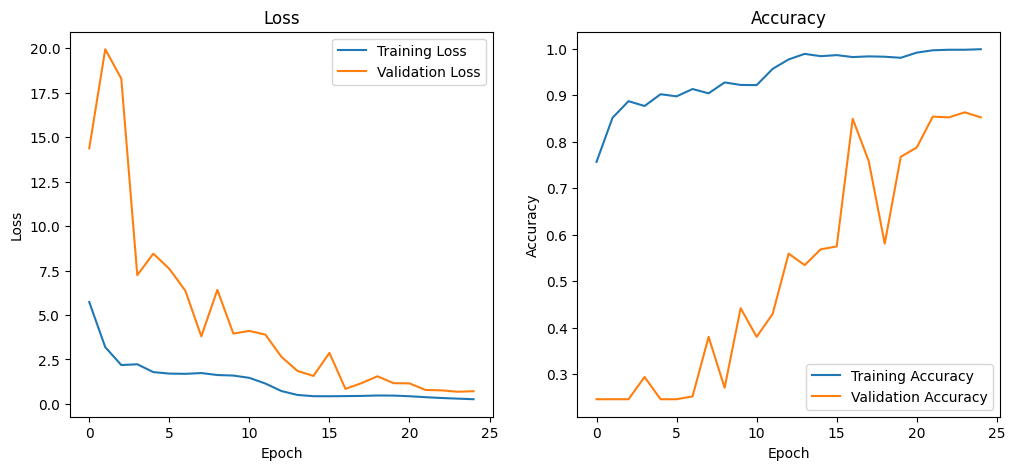

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


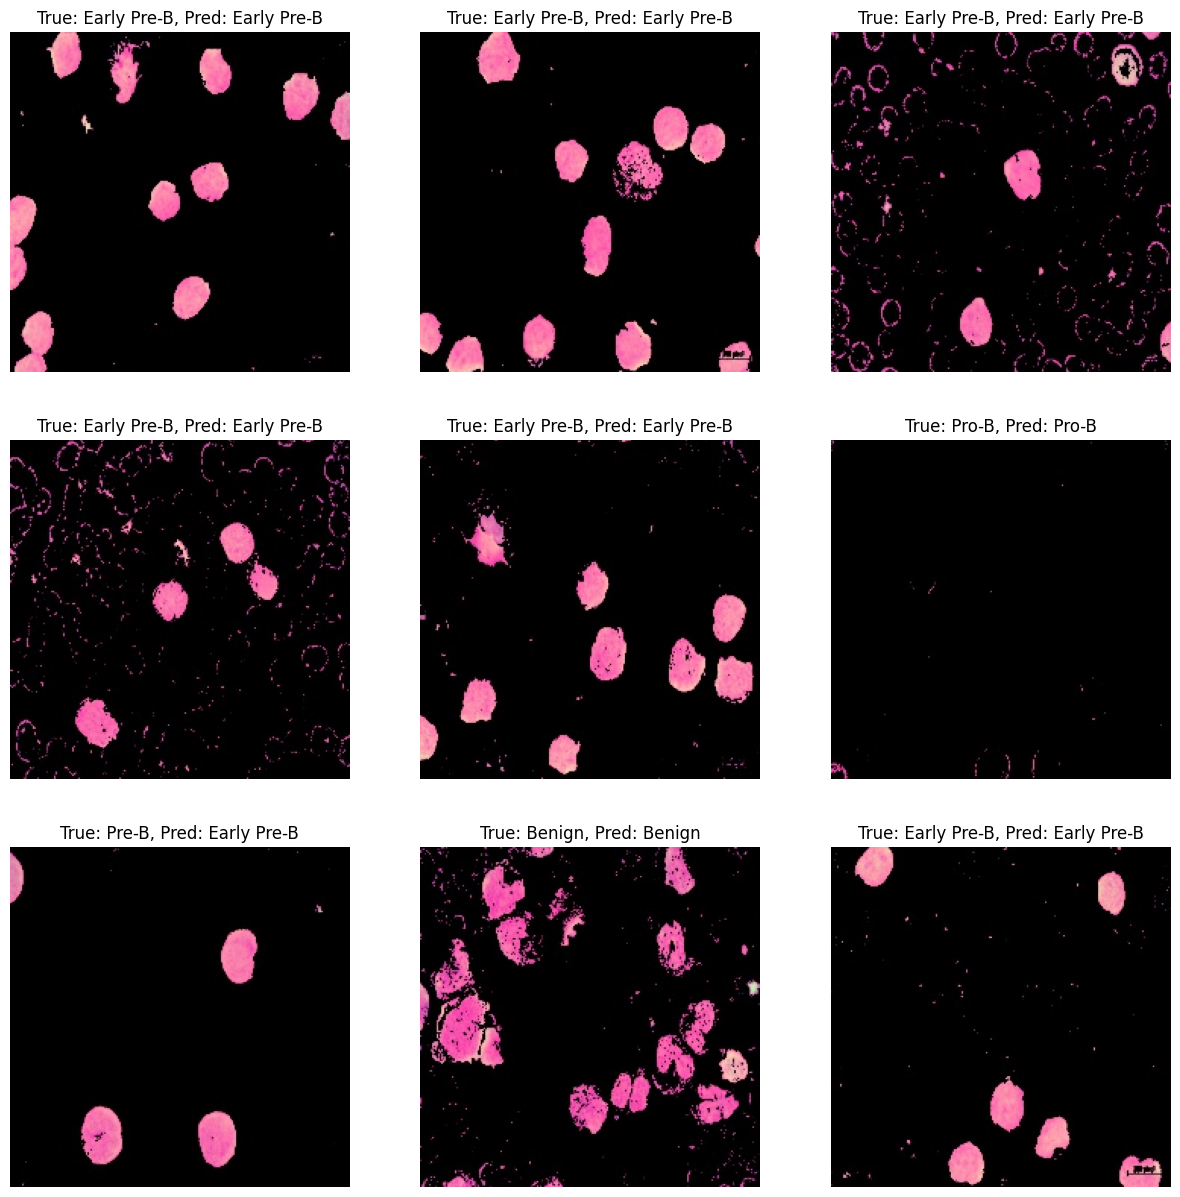

In [ ]:
# Define the CNN model with L2 regularization and Batch Normalization
model_seg = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model_seg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

checkpoint = ModelCheckpoint('model_seg.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model_seg
history_seg = model_seg.fit(
    segmented_train_datagen,
    validation_data=segmented_val_datagen,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# model_seg.save('model_seg.keras')

plot_history(history_seg)

# Get a batch of validation data
sample_images, sample_labels = next(segmented_val_datagen)

# Predict the classes for the sample images
predictions = model_seg.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)
save_data_and_model(model_seg, sample_images, sample_labels, predictions)

# Class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = predicted_classes[i]
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.show()


Observation:
* Accurate classification of blood cell development stages and benign cells.
* 25 epochs of training.
* Training accuracy improved from about 70% to nearly 100%.
* Validation accuracy increased from around 25% to about 85%.
* Training loss decreased from about 6.2 to 0.27.
* Validation loss decreased from about 14 to 0.7.
* Overfitting indicated a bit by nearly 100% training accuracy vs. 85% validation accuracy.
* Learning rate adjustments: 0.001 (epochs 1-11) → 0.0002 (epochs 12-20) → 0.00004 (epochs 21-25).
* Confident predictions with only one misclassification.


In [ ]:
model_seg.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,511,246 (127.84 MB)

 Trainable params: 11,170,180 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 22,340,362 (85.22 MB)

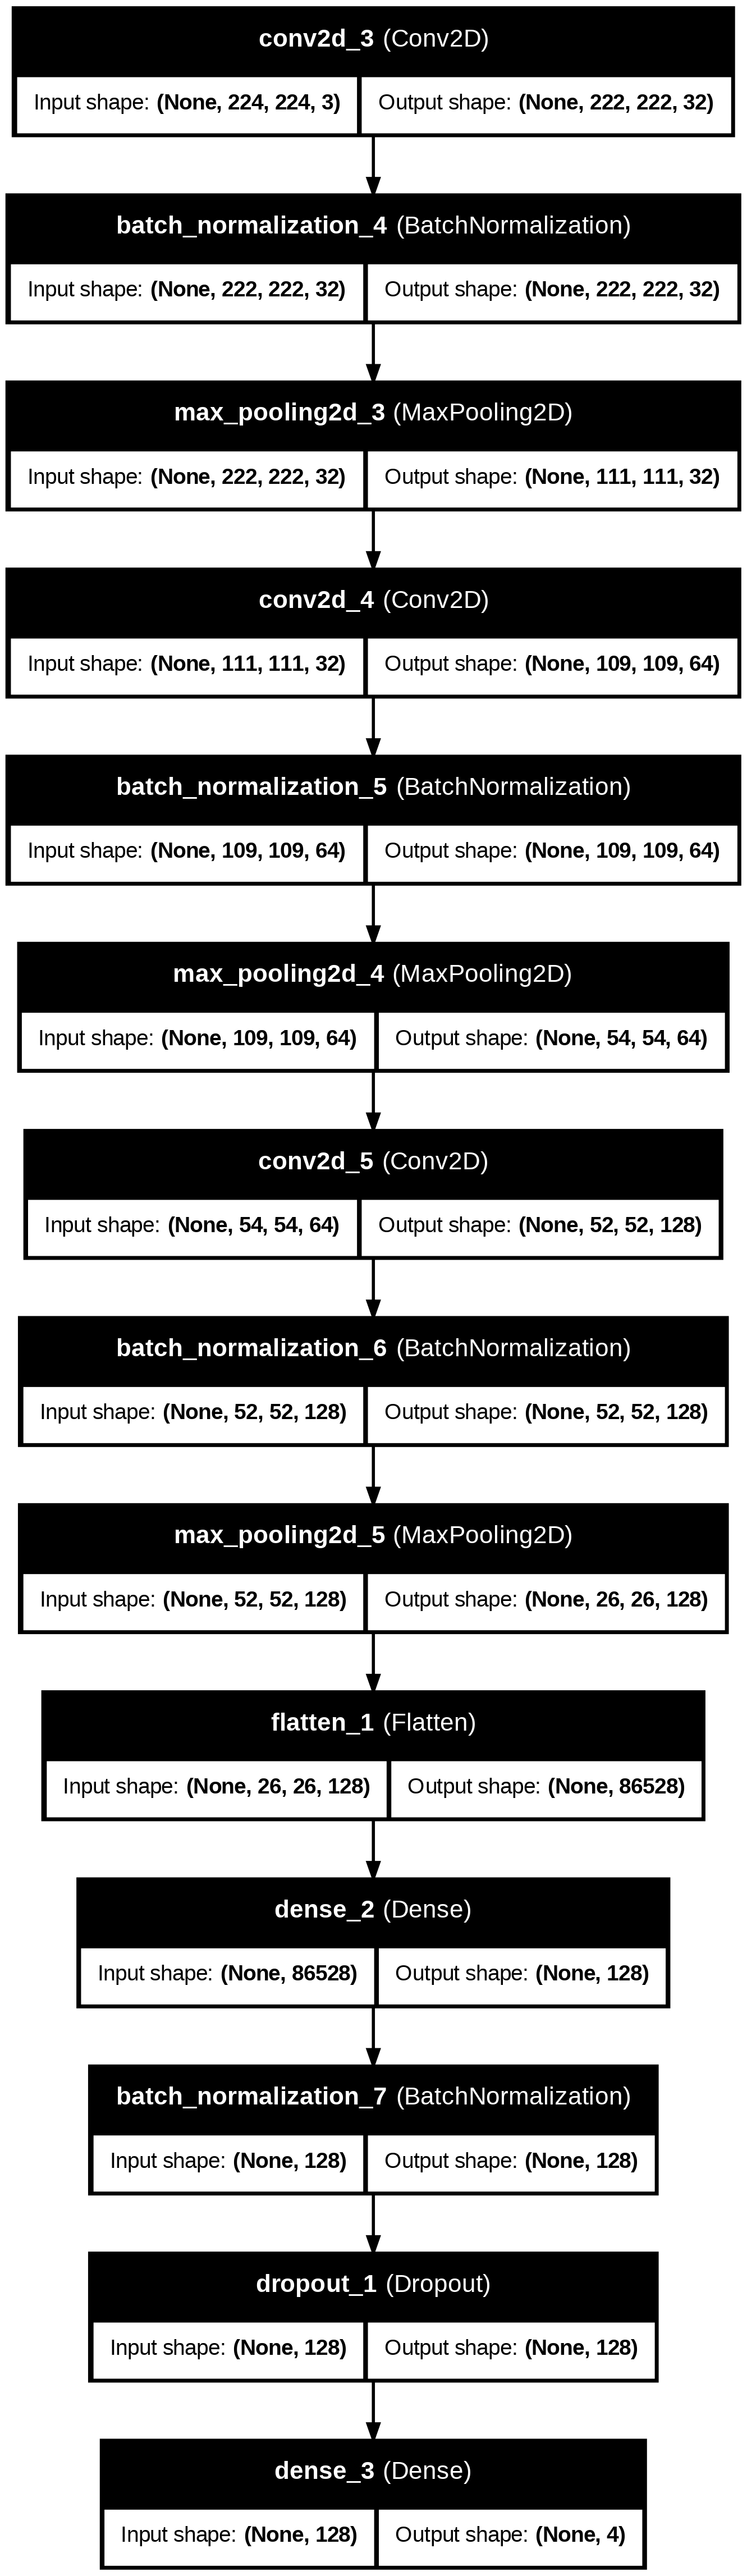

In [ ]:
plot_model(model_seg, to_file='model_seg.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_seg.png'))


# Combined

In [ ]:
def combined_generator(gen1, gen2):
    while True:
        X1i, y1i = next(gen1)
        X2i, y2i = next(gen2)
        yield np.concatenate((X1i, X2i), axis=0), np.concatenate((y1i, y2i), axis=0)

combined_train_datagen = combined_generator(original_train_datagen, segmented_train_datagen)
combined_val_datagen = combined_generator(original_val_datagen, segmented_val_datagen)

Epoch 1/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 59s 291ms/step - accuracy: 0.6846 - loss: 5.5435 - val_accuracy: 0.1539 - val_loss: 3.4247 - learning_rate: 0.0010
Epoch 2/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 33s 204ms/step - accuracy: 0.8640 - loss: 1.7679 - val_accuracy: 0.3509 - val_loss: 2.7717 - learning_rate: 0.0010
Epoch 3/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 30s 186ms/step - accuracy: 0.9142 - loss: 1.2341 - val_accuracy: 0.4376 - val_loss: 3.5902 - learning_rate: 0.0010
Epoch 4/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 40s 248ms/step - accuracy: 0.9231 - loss: 1.1284 - val_accuracy: 0.8067 - val_loss: 1.4290 - learning_rate: 0.0010
Epoch 5/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 30s 182ms/step - accuracy: 0.9308 - loss: 1.0568 - val_accuracy: 0.7257 - val_loss: 1.7977 - learning_rate: 0.0010
Epoch 6/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 28s 172ms/step - accuracy: 0.9373 - loss: 1.0290 - val_accuracy: 0.5952 - val_loss: 1.8289 - learning_rate: 0.0010
Epoch 7/25
162/162 ━━━━━━━━━━━━━━━━━━━━ 29s 181ms/step - accuracy: 0.9

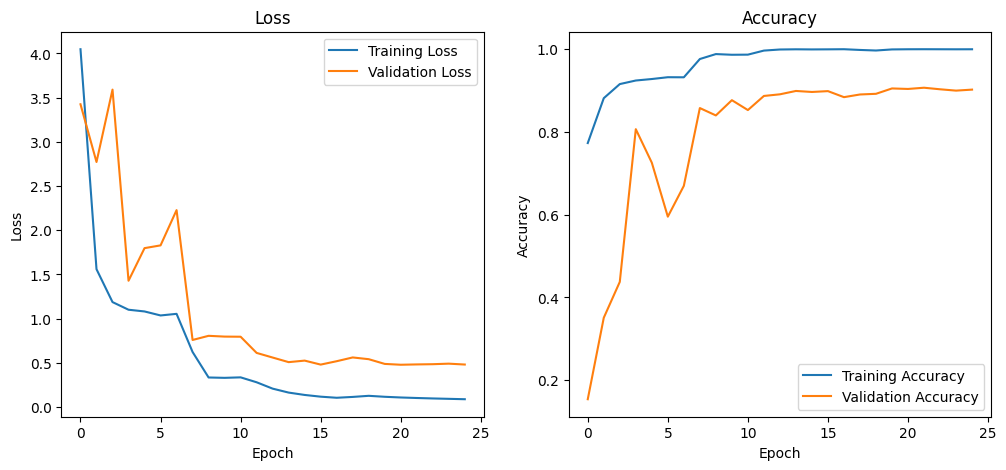

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 


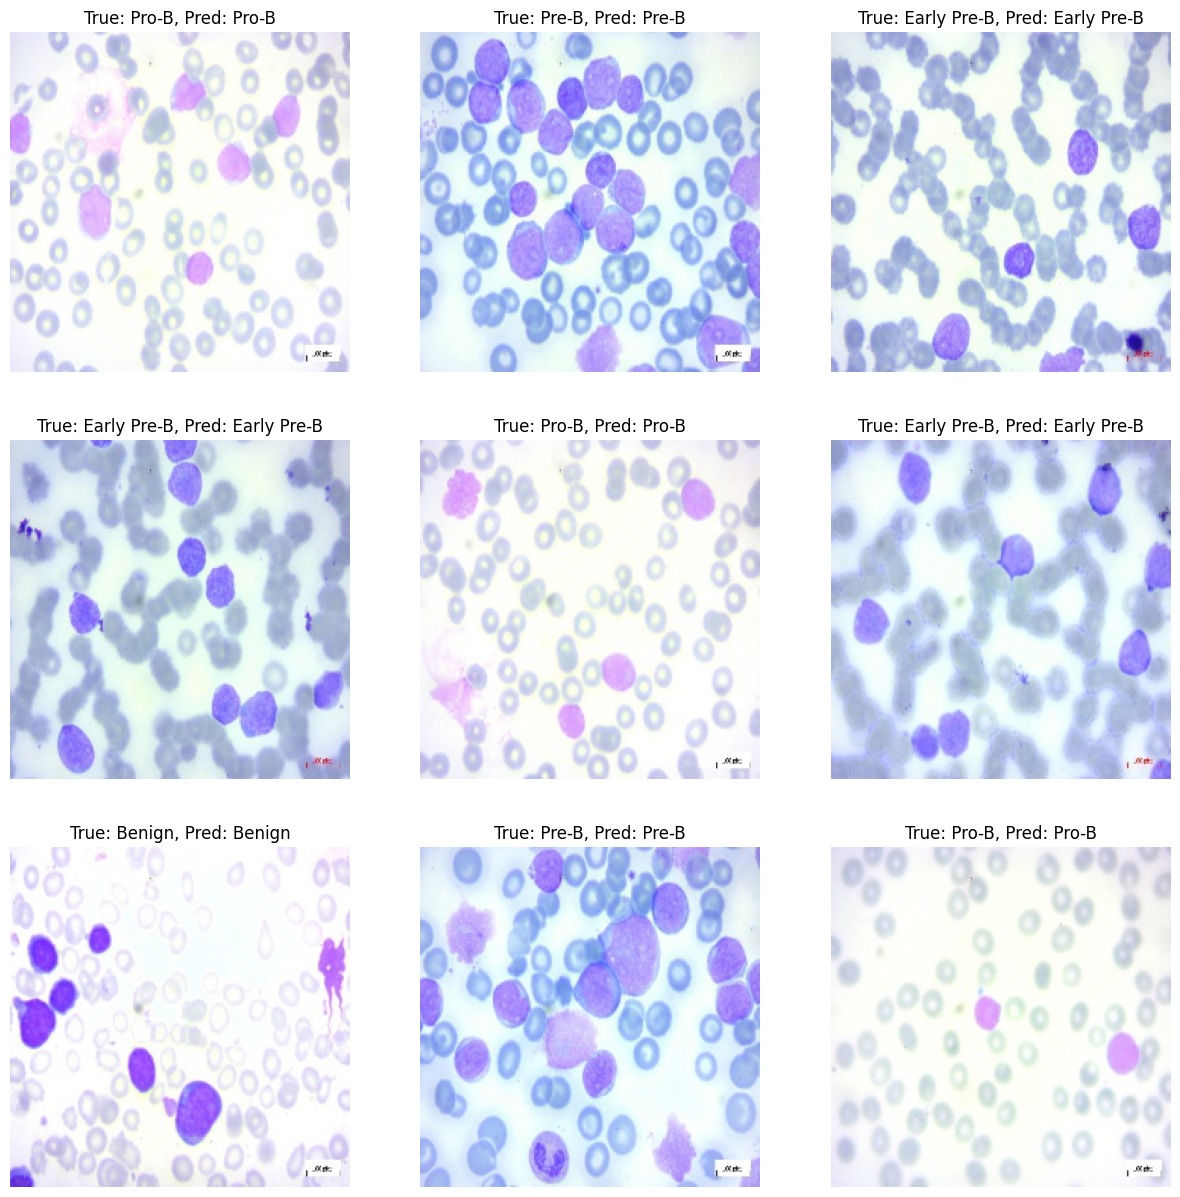

In [ ]:
# Define the CNN model with L2 regularization and Batch Normalization
batch_size = 32

# Calculate the number of steps per epoch for training
train_steps_per_epoch = sum([original_train_datagen.samples, segmented_train_datagen.samples]) // batch_size

# Calculate the number of validation steps
validation_steps = sum([original_val_datagen.samples, segmented_val_datagen.samples]) // batch_size

# Define the CNN model with L2 regularization and Batch Normalization
model_combined = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3), kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define early stopping and reduce learning rate on plateau
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)
checkpoint = ModelCheckpoint('model_combined.keras', save_best_only=True, monitor='val_loss', mode='min')

# Train the model
history_combined = model_combined.fit(
    combined_train_datagen,
    validation_data=combined_val_datagen,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=validation_steps,
    epochs=25,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

# Call the plot_history function to visualize the training history
plot_history(history_combined)

# Get a batch of validation data
sample_images, sample_labels = next(combined_val_datagen)

# Predict the classes for the sample images
predictions = model_combined.predict(sample_images)
predicted_classes = np.argmax(predictions, axis=1)

# Class names
class_names = ['Benign', 'Early Pre-B', 'Pre-B', 'Pro-B']

# Plot the images with their true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    true_label = np.argmax(sample_labels[i])
    predicted_label = predicted_classes[i]
    plt.title(f"True: {class_names[true_label]}, Pred: {class_names[predicted_label]}")
    plt.axis('off')
plt.show()

Observation:
* Accurate classification of blood cell development stages and benign cells.
* 25 epochs of training.
* Training accuracy improved from 68% to nearly 100%.
* Validation accuracy increased from 15% to about 90%.
* Training loss decreased from 5.5 to 0.09.
* Validation loss decreased from 3.4 to 0.48.
* Overfitting indicated by 100% training accuracy vs. 90% validation accuracy.
* Learning rate adjustments: 0.001 (epochs 1-7) → 0.0002 (epochs 8-11) → 0.00004 (epochs 12-19) → 0.00001 (epochs 20-25).
* Varied cell sizes, shapes, and nuclear characteristics aided differentiation.
* Confident predictions with no misclassifications.

In [ ]:
model_combined.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 222, 222, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 109, 109, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 52, 52, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │             516 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,511,246 (127.84 MB)

 Trainable params: 11,170,180 (42.61 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 22,340,362 (85.22 MB)

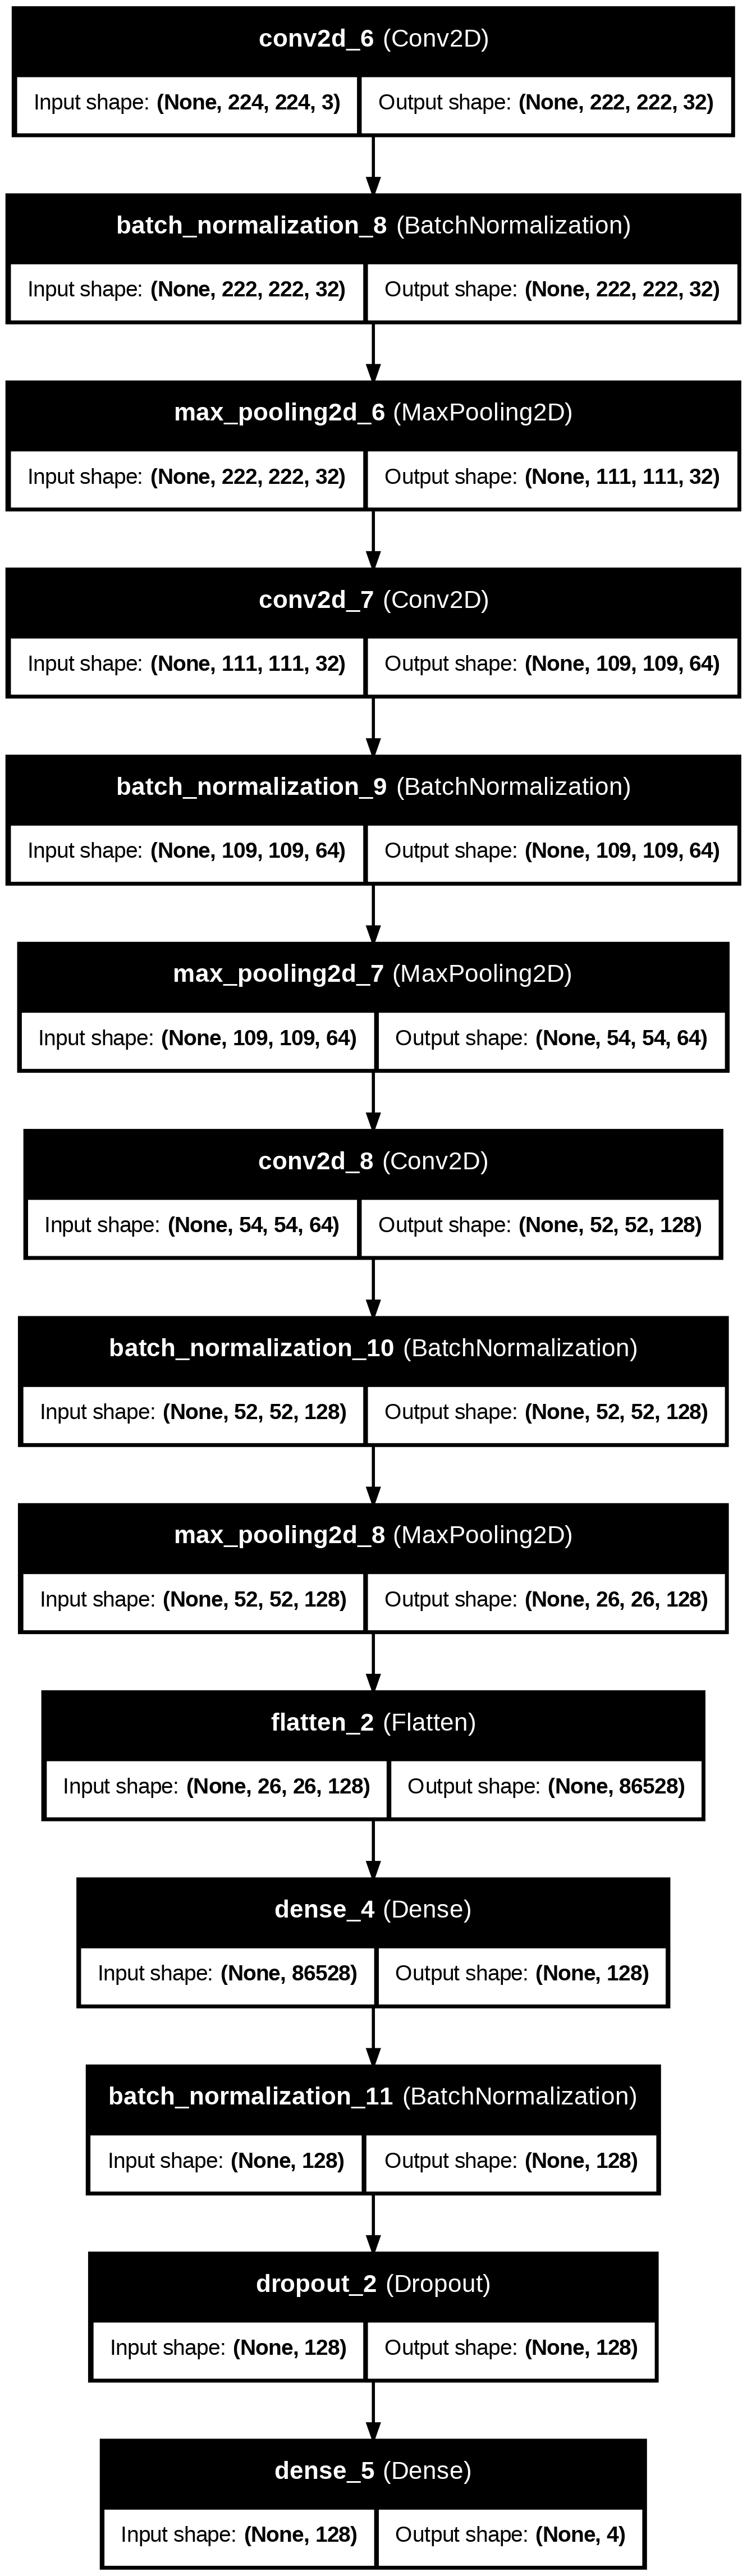

In [ ]:
plot_model(model_combined, to_file='model_combined.png', show_shapes=True, show_layer_names=True)
display(Image(filename='model_combined.png'))


# Comparision visuals

## Correlation matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


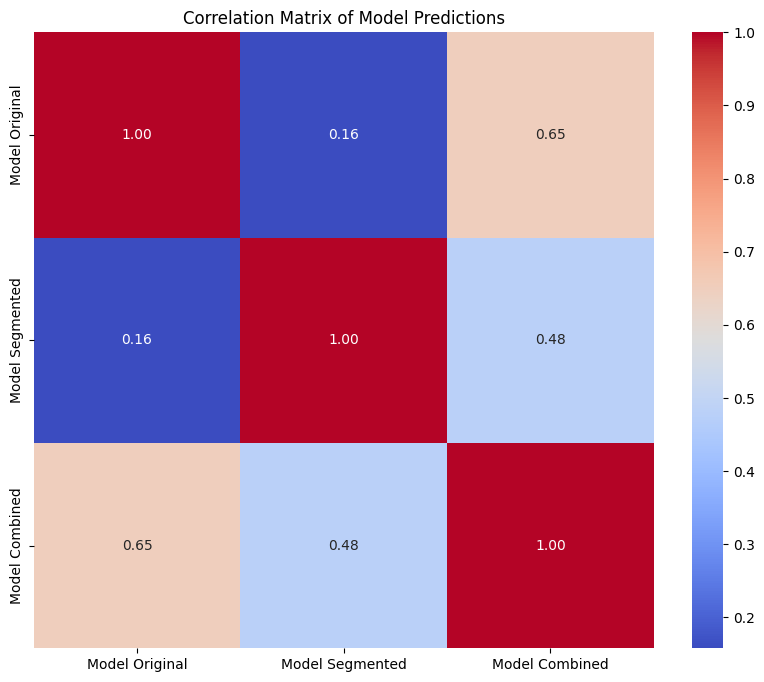

In [ ]:
#correlation matrix
predictions1 = model.predict(sample_images)
predictions_seg = model_seg.predict(sample_images)
predictions_combined = model_combined.predict(sample_images)

# Convert predictions to class labels
predicted_classes1 = np.argmax(predictions1, axis=1)
predicted_classes_seg = np.argmax(predictions_seg, axis=1)
predicted_classes_combined = np.argmax(predictions_combined, axis=1)

# Create a DataFrame with predictions
predictions_df = pd.DataFrame({
    'Model Original': predicted_classes1,
    'Model Segmented': predicted_classes_seg,
    'Model Combined': predicted_classes_combined
})

# Calculate the correlation matrix
correlation_matrix = predictions_df.corr()

# Visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Model Predictions')
plt.show()

Observation:
* Perfect self-correlation (1.00) for all models, as expected
* Weak positive correlation (0.16) between Original and Segmented models
* Strong positive correlation (0.65) between Original and Combined models
* Moderate positive correlation (0.48) between Segmented and Combined models
* Original model shows highest correlation with Combined model
* Segmented model has lowest correlation with other models
* Combined model shows moderate to strong correlation with both Original and Segmented

## Comparison of Accuracy and Loss

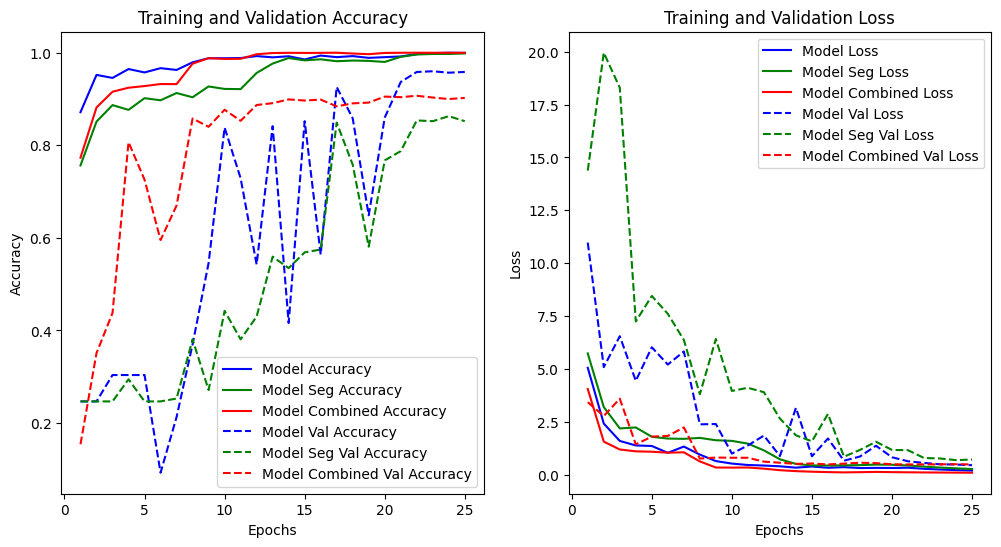

In [ ]:
def plot_comparison(history, history_seg, history_combined):
    epochs = range(1, len(history.history['accuracy']) + 1)

    plt.figure(figsize=(12, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history.history['accuracy'], 'b-', label='Model Accuracy')
    plt.plot(epochs, history_seg.history['accuracy'], 'g-', label='Model Seg Accuracy')
    plt.plot(epochs, history_combined.history['accuracy'], 'r-', label='Model Combined Accuracy')
    plt.plot(epochs, history.history['val_accuracy'], 'b--', label='Model Val Accuracy')
    plt.plot(epochs, history_seg.history['val_accuracy'], 'g--', label='Model Seg Val Accuracy')
    plt.plot(epochs, history_combined.history['val_accuracy'], 'r--', label='Model Combined Val Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history.history['loss'], 'b-', label='Model Loss')
    plt.plot(epochs, history_seg.history['loss'], 'g-', label='Model Seg Loss')
    plt.plot(epochs, history_combined.history['loss'], 'r-', label='Model Combined Loss')
    plt.plot(epochs, history.history['val_loss'], 'b--', label='Model Val Loss')
    plt.plot(epochs, history_seg.history['val_loss'], 'g--', label='Model Seg Val Loss')
    plt.plot(epochs, history_combined.history['val_loss'], 'r--', label='Model Combined Val Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

plot_comparison(history, history_seg, history_combined)


Observations:
* All models improve in accuracy and decrease in loss over time.
* Model Combined achieves highest stable validation accuracy and lowest overall loss.
* Model Seg shows most erratic validation accuracy and highest initial loss spike.
* Training accuracy reaches near-perfect for all models, with Model and Model Combined improving fastest.
* Validation metrics show high variability across all models.
* Signs of overfitting present, most notably in Model Seg.
* All models converge to similar low loss by final epochs.
* Model Combined demonstrates best overall performance and stability.

# Future work
* Tweaking the model: We want to play around with the model's structure, maybe making it deeper or trying out different types of layers. It's like fine-tuning an engine to get better performance.
* Learning from others: We're considering using pre-trained models that have already learned from tons of images. It's like standing on the shoulders of giants to see further.
* Teaching the model to focus: We want to add something called "attention mechanisms." Imagine teaching the model to focus on the most important parts of an image, just like a doctor would.
* Strength in numbers: We might combine multiple models, each with its own strengths, to create a super-team of leukemia detectors.
* More practice makes perfect: We plan to feed our model more and more diverse images. The more it sees, the better it'll get at spotting leukemia.
* Reality check: We'll team up with actual doctors to test our model in real-world situations. Their feedback will be crucial to make sure our system is truly helpful in clinics.